<a href="https://colab.research.google.com/github/bryandaetz1/Churn_Prediction/blob/master/Bryan_Daetz_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
telco_data =  pd.read_csv('https://raw.githubusercontent.com/cjflanagan/cs68/master/Telco-Customer-Churn.csv')

In [3]:
telco_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
telco_data.Churn.value_counts()

No     3738
Yes    1332
Name: Churn, dtype: int64

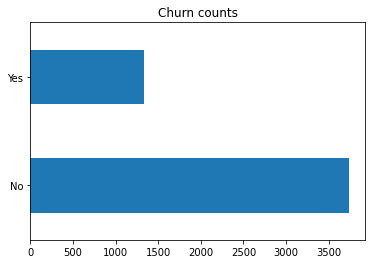

In [5]:
telco_data.Churn.value_counts().plot(kind='barh', title='Churn counts')
plt.show() 

In [6]:
telco_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5070 entries, 0 to 5069
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5070 non-null   object 
 1   gender            5070 non-null   object 
 2   SeniorCitizen     5070 non-null   int64  
 3   Partner           5070 non-null   object 
 4   Dependents        5070 non-null   object 
 5   tenure            5070 non-null   int64  
 6   PhoneService      5070 non-null   object 
 7   MultipleLines     5070 non-null   object 
 8   InternetService   5070 non-null   object 
 9   OnlineSecurity    5070 non-null   object 
 10  OnlineBackup      5070 non-null   object 
 11  DeviceProtection  5070 non-null   object 
 12  TechSupport       5070 non-null   object 
 13  StreamingTV       5070 non-null   object 
 14  StreamingMovies   5070 non-null   object 
 15  Contract          5070 non-null   object 
 16  PaperlessBilling  5070 non-null   object 


In [7]:
#getting categorical columns
categorical_cols = telco_data.columns[telco_data.dtypes == 'object'].tolist()

#getting subgroups for binary vs. multi-valued
multi_val_cols = telco_data[categorical_cols].nunique()[telco_data[categorical_cols].nunique() > 2].index.tolist()
binary_cols = telco_data[categorical_cols].nunique()[telco_data[categorical_cols].nunique() == 2].index.tolist()


In [8]:
multi_val_cols

['customerID',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'TotalCharges']

In [9]:
#checking values for binary columns
telco_data[binary_cols].head()

,gender,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,Female,Yes,No,No,Yes,No
1,Male,No,No,Yes,No,No
2,Male,No,No,Yes,Yes,Yes
3,Male,No,No,No,No,No
4,Female,No,No,Yes,Yes,Yes


In [10]:
#converting binary columns to numerical values
telco_data[binary_cols] = telco_data[binary_cols].replace({'Yes': 1, 'No': 0, 'Male': 1,'Female': 0})
telco_data[binary_cols].head()

,gender,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,0,1,0,0,1,0
1,1,0,0,1,0,0
2,1,0,0,1,1,1
3,1,0,0,0,0,0
4,0,0,0,1,1,1


In [11]:
#checking values for multi-valued columns
telco_data[multi_val_cols].head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,TotalCharges
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Electronic check,29.85
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No,One year,Mailed check,1889.5
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Mailed check,108.15
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,Bank transfer (automatic),1840.75
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check,151.65


In [12]:
#getting value counts for each column
for col in telco_data[multi_val_cols]:
  print(col, '\n', telco_data[col].value_counts(), '\n')


customerID 
 1073-XXCZD    1
3230-WYKIR    1
9367-OIUXP    1
7306-YDSOI    1
7311-MQJCH    1
             ..
4092-OFQZS    1
5067-XJQFU    1
9488-HGMJH    1
0811-GSDTP    1
9512-UIBFX    1
Name: customerID, Length: 5070, dtype: int64 

MultipleLines 
 No                  2436
Yes                 2163
No phone service     471
Name: MultipleLines, dtype: int64 

InternetService 
 Fiber optic    2223
DSL            1734
No             1113
Name: InternetService, dtype: int64 

OnlineSecurity 
 No                     2504
Yes                    1453
No internet service    1113
Name: OnlineSecurity, dtype: int64 

OnlineBackup 
 No                     2213
Yes                    1744
No internet service    1113
Name: OnlineBackup, dtype: int64 

DeviceProtection 
 No                     2207
Yes                    1750
No internet service    1113
Name: DeviceProtection, dtype: int64 

TechSupport 
 No                     2510
Yes                    1447
No internet service    1113
Name: Tec

In [13]:
#with the exception of customerID (which appears to be unique for each row) and TotalCharges (which should be converted to a float) we should be able to convert the multi-valued columns into dummy variables

#removing customerID and TotalChargesfrom list of multi-valued columns
multi_val_cols = multi_val_cols[1:-1]
multi_val_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [14]:
#creating dummy variables, setting drop_first to True so that only n-1 dummy variables are created for each multi-valued categorical variable
telco_data_adjusted = pd.get_dummies(data = telco_data, columns = multi_val_cols, drop_first = True)
telco_data_adjusted.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.5,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [15]:
#looks like there are 8 values of TotalCharges were no amount was reported, this values all have a monthly charges amount so the ' ' doesn't correspond to a 0
telco_data_adjusted.loc[telco_data_adjusted['TotalCharges'] == ' ']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
488,4472-LVYGI,0,0,1,1,0,0,1,52.55,,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
753,3115-CZMZD,1,0,0,1,0,1,0,20.25,,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1
936,5709-LVOEQ,0,0,1,1,0,1,0,80.85,,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1
1082,4367-NUYAO,1,0,1,1,0,1,0,25.75,,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1
1340,1371-DWPAZ,0,0,1,1,0,0,0,56.05,,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0
3331,7644-OMVMY,1,0,1,1,0,1,0,19.85,,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1
3826,3213-VVOLG,1,0,1,1,0,1,0,25.35,,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1
4380,2520-SGTTA,0,0,1,1,0,1,0,20.00,,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1


In [16]:
telco_data_adjusted.shape

(5070, 32)

In [17]:
#drop missing values, since there are only 8 I elected to just drop these missing values
rows_to_drop = telco_data_adjusted.loc[telco_data_adjusted['TotalCharges'] == ' '].index.tolist()
telco_data_adjusted.drop(telco_data_adjusted.index[rows_to_drop], axis = 0, inplace = True)

#converting TotalCharges to numeric
telco_data_adjusted['TotalCharges'] = pd.to_numeric(telco_data_adjusted['TotalCharges'])

#dropping customerID column
telco_data_adjusted.drop('customerID', axis = 1, inplace = True)

telco_data_adjusted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5062 entries, 0 to 5069
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 5062 non-null   int64  
 1   SeniorCitizen                          5062 non-null   int64  
 2   Partner                                5062 non-null   int64  
 3   Dependents                             5062 non-null   int64  
 4   tenure                                 5062 non-null   int64  
 5   PhoneService                           5062 non-null   int64  
 6   PaperlessBilling                       5062 non-null   int64  
 7   MonthlyCharges                         5062 non-null   float64
 8   TotalCharges                           5062 non-null   float64
 9   Churn                                  5062 non-null   int64  
 10  MultipleLines_No phone service         5062 non-null   uint8  
 11  Mult

In [18]:
telco_data_adjusted.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [19]:
#manually normalizing columns with range outside (0,1)
telco_data_adjusted['tenure'] = telco_data_adjusted['tenure'] / telco_data_adjusted['tenure'].max(axis = 0)
telco_data_adjusted['MonthlyCharges'] = telco_data_adjusted['tenure'] / telco_data_adjusted['tenure'].max(axis = 0)
telco_data_adjusted['TotalCharges'] = telco_data_adjusted['tenure'] / telco_data_adjusted['tenure'].max(axis = 0)
telco_data_adjusted.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,0.013889,0,1,0.013889,0.013889,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0.472222,1,0,0.472222,0.472222,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,0.027778,1,1,0.027778,0.027778,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0.625000,0,0,0.625000,0.625000,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0.027778,1,1,0.027778,0.027778,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


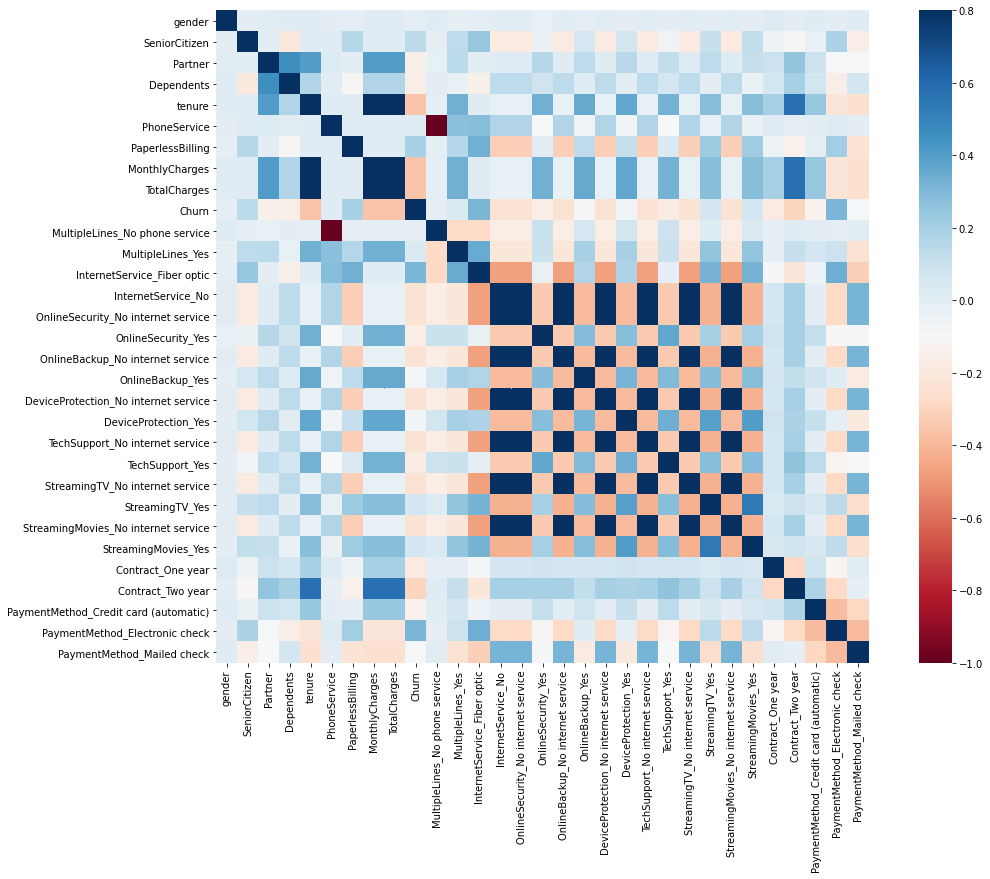

In [20]:
#generating heatmap to check for mulitcollinearity
corr_map = telco_data_adjusted.corr()
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(corr_map, square = True, vmax = 0.8, cmap = 'RdBu')

#looks like there is definitely some multicollinearity going on between columns with 'No internet service', would probably be best to remove those and just use the 'InternetService_No' column

In [21]:
y = telco_data_adjusted['Churn'] # Removing Churn field and storing it in variable y

#'No internet service' columns are highly correlated, dropping all but the 'InternetService_No' column
# 'tenure', 'MonthlyCharges' and 'TotalCharges' are highly correlated, dropping all but most impactful of the three ('TotalCharges')
# 'PhoneService" and "MultipleLines_No phone service" are highly correlated, dropping 'MultipleLines_No phone service
# found 'PaymentMethod_Credit card (automatic)' and 'Partner' are not very impactful through testing model, dropping these features as well
X = telco_data_adjusted.drop(['Churn',
                              'OnlineSecurity_No internet service',
                              'OnlineBackup_No internet service',
                              'DeviceProtection_No internet service',
                              'TechSupport_No internet service',
                              'StreamingTV_No internet service',
                              'StreamingMovies_No internet service',
                              'tenure',
                              'MonthlyCharges',
                              'MultipleLines_No phone service',
                              'PaymentMethod_Credit card (automatic)',
                              'Partner'],
                               axis = 1) # independent variables

In [22]:
#final check for null values
X.isna().sum()

gender                            0
SeniorCitizen                     0
Dependents                        0
PhoneService                      0
PaperlessBilling                  0
TotalCharges                      0
MultipleLines_Yes                 0
InternetService_Fiber optic       0
InternetService_No                0
OnlineSecurity_Yes                0
OnlineBackup_Yes                  0
DeviceProtection_Yes              0
TechSupport_Yes                   0
StreamingTV_Yes                   0
StreamingMovies_Yes               0
Contract_One year                 0
Contract_Two year                 0
PaymentMethod_Electronic check    0
PaymentMethod_Mailed check        0
dtype: int64

# Splitting data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [24]:
X_train.head()

,gender,SeniorCitizen,Dependents,PhoneService,PaperlessBilling,TotalCharges,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Electronic check,PaymentMethod_Mailed check
1045,0,0,1,1,1,0.597222,1,1,0,0,0,1,0,1,1,0,0,0,0
1430,0,0,0,1,0,0.319444,1,0,1,0,0,0,0,0,0,1,0,0,0
356,0,1,0,1,1,0.222222,1,0,0,1,0,0,0,0,0,0,0,1,0
1166,0,0,0,1,1,0.069444,1,0,0,1,0,0,0,0,0,0,0,1,0
4662,1,0,1,1,0,0.305556,0,0,1,0,0,0,0,0,0,0,0,0,0


# Fitting model

In [25]:
# fit a model
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = clf.predict_proba(X_test)[:, 1]

# Evaluating model

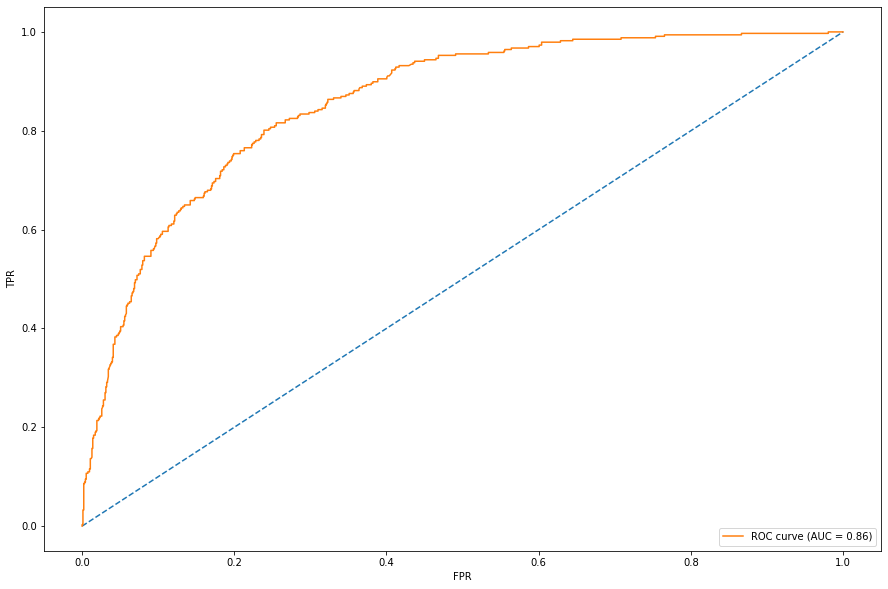

In [26]:
# calculate scores
auc = roc_auc_score(y_test, predictions)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(15, 10))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

In [27]:
from sklearn.metrics import classification_report
pred_binary = clf.predict(X_test)
print(classification_report(y_test, pred_binary))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       929
           1       0.65      0.61      0.63       337

    accuracy                           0.81      1266
   macro avg       0.76      0.75      0.75      1266
weighted avg       0.81      0.81      0.81      1266



In [28]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred_binary))

[[820 109]
 [131 206]]


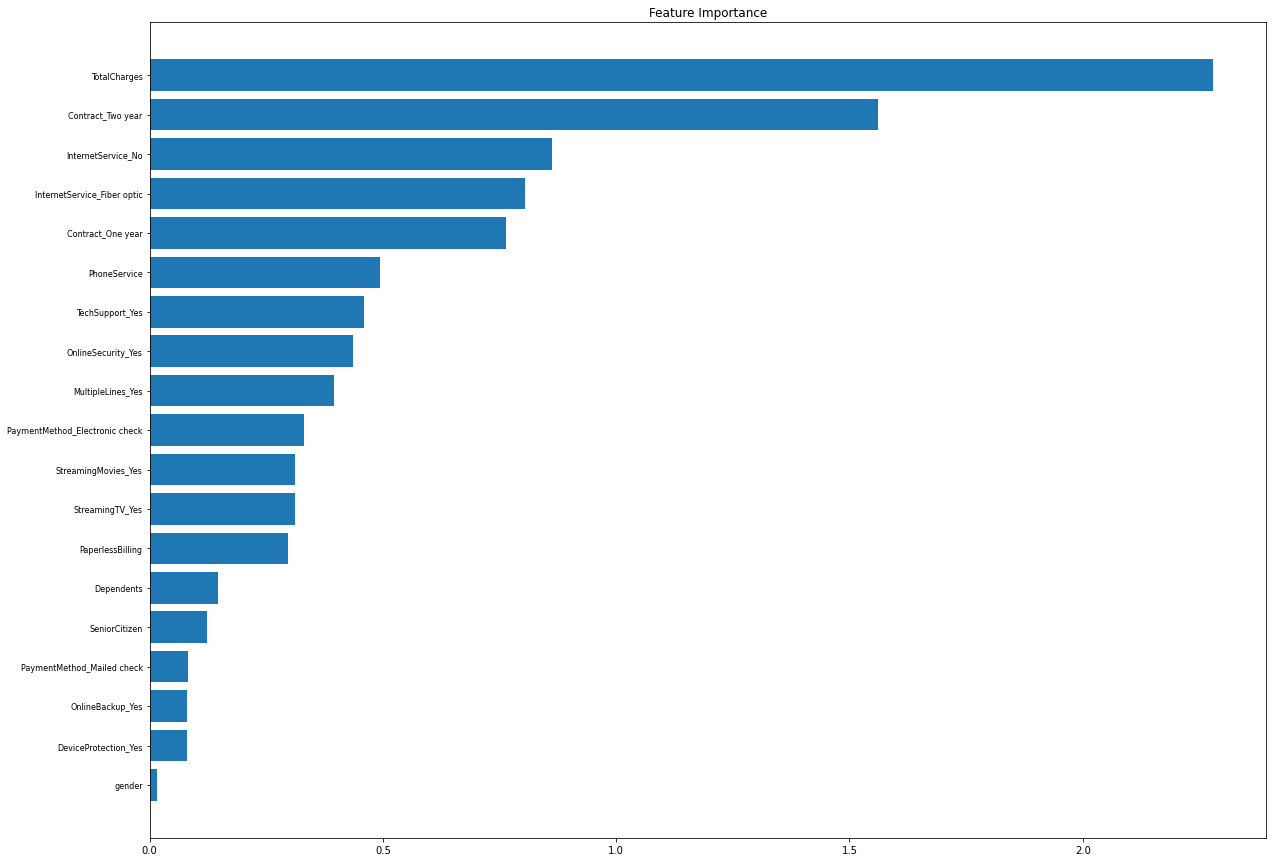

In [29]:
feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize = (20,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.title('Feature Importance')
plt.show()